# 1. Import libraries

In [1]:
#----------------------------Reproducible----------------------------------------------------------------------------------------
import numpy as np
import tensorflow as tf
import random as rn
import os

seed=0
os.environ['PYTHONHASHSEED'] = str(seed)

np.random.seed(seed)
rn.seed(seed)
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
session_conf =tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

#tf.set_random_seed(seed)
tf.compat.v1.set_random_seed(seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)

K.set_session(sess)
#----------------------------Reproducible----------------------------------------------------------------------------------------

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#--------------------------------------------------------------------------------------------------------------------------------
from keras.datasets import fashion_mnist
from keras.models import Model
from keras.layers import Dense, Input, Flatten, Activation, Dropout, Layer
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import optimizers,initializers,constraints,regularizers
from keras import backend as K
from keras.callbacks import LambdaCallback,ModelCheckpoint
from keras.utils import plot_model

from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import h5py
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
matplotlib.style.use('ggplot')

import random
import scipy.sparse as sparse
import pandas as pd
from skimage import io
from PIL import Image
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse

#--------------------------------------------------------------------------------------------------------------------------------
#Import ourslef defined methods
import sys
sys.path.append(r"./Defined")
import Functions as F

# The following code should be added before the keras model
#np.random.seed(seed)

Using TensorFlow backend.


In [2]:
#--------------------------------------------------------------------------------------------------------------------------------
def write_to_csv(p_data,p_path):
    dataframe = pd.DataFrame(p_data)
    dataframe.to_csv(p_path, mode='a',header=False,index=False,sep=',')
    del dataframe

# 2. Loading data

In [3]:
dataset_path='./Dataset/coil-20-proc/'

samples={}
for dirpath, dirnames, filenames in os.walk(dataset_path):
    #print(dirpath)
    #print(dirnames)
    #print(filenames)
    dirnames.sort()
    filenames.sort()
    for filename in [f for f in filenames if f.endswith(".png") and not f.find('checkpoint')>0]:
        full_path = os.path.join(dirpath, filename)
        file_identifier=filename.split('__')[0][3:]
        if file_identifier not in samples.keys():
            samples[file_identifier] = []
        # Direct read
        #image = io.imread(full_path)
        # Resize read
        image_=Image.open(full_path).resize((20, 20),Image.ANTIALIAS)
        image=np.asarray(image_)
        samples[file_identifier].append(image)
        
#plt.imshow(samples['1'][0].reshape(20,20))

In [4]:
data_arr_list=[]
label_arr_list=[]
for key_i in samples.keys():
    key_i_for_label=[int(key_i)-1]
    data_arr_list.append(np.array(samples[key_i]))
    label_arr_list.append(np.array(72*key_i_for_label))
    
data_arr=np.concatenate(data_arr_list).reshape(1440, 20*20).astype('float32') / 255.
label_arr_onehot=to_categorical(np.concatenate(label_arr_list))

Shape of x_train: (499, 400)
Shape of x_test: (288, 400)
Shape of y_train: (499, 20)
Shape of y_test: (288, 20)


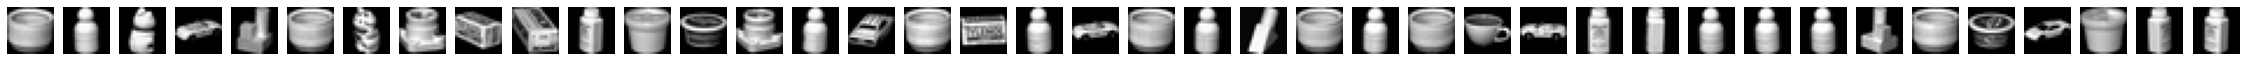

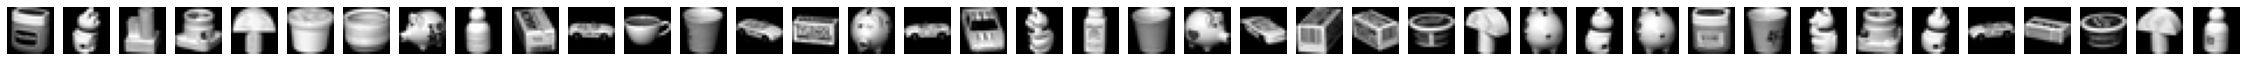

In [5]:
sample_used=499

x_train_all,x_test,y_train_all,y_test_onehot= train_test_split(data_arr,label_arr_onehot,test_size=0.2,random_state=seed)

x_train=x_train_all[0:sample_used]
y_train_onehot=y_train_all[0:sample_used]

print('Shape of x_train: ' + str(x_train.shape)) 
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train_onehot.shape))
print('Shape of y_test: ' + str(y_test_onehot.shape))

F.show_data_figures(x_train[0:40],20,20,40)
F.show_data_figures(x_test[0:40],20,20,40)

In [6]:
key_feture_number=50

# 3.Model

In [7]:
np.random.seed(seed)

#--------------------------------------------------------------------------------------------------------------------------------
class Feature_Select_Layer(Layer):
    
    def __init__(self, output_dim, **kwargs):
        super(Feature_Select_Layer, self).__init__(**kwargs)
        self.output_dim = output_dim

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',  
                                      shape=(input_shape[1],),
                                      initializer=initializers.RandomUniform(minval=0.999999, maxval=0.9999999, seed=seed),
                                      trainable=True)
        super(Feature_Select_Layer, self).build(input_shape)
    
    def call(self, x, selection=False,k=key_feture_number):
        kernel=K.abs(self.kernel)      
        if selection:
            kernel_=K.transpose(kernel)
            kth_largest = tf.math.top_k(kernel_, k=k)[0][-1]
            kernel = tf.where(condition=K.less(kernel,kth_largest),x=K.zeros_like(kernel),y=kernel)        
        return K.dot(x, tf.linalg.tensor_diag(kernel))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

#--------------------------------------------------------------------------------------------------------------------------------
def Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                        p_feture_number=key_feture_number,\
                        p_encoding_dim=key_feture_number,\
                        p_learning_rate=1E-3,\
                        p_loss_weight_1=1,\
                        p_loss_weight_2=2):
    
    input_img = Input(shape=(p_data_feature,), name='autoencoder_input')

    feature_selection = Feature_Select_Layer(output_dim=p_data_feature,\
                                             input_shape=(p_data_feature,),\
                                             name='feature_selection')

    feature_selection_score=feature_selection(input_img)
    feature_selection_choose=feature_selection(input_img,selection=True,k=p_feture_number)

    encoded = Dense(p_encoding_dim,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_hidden_layer')
    
    encoded_score=encoded(feature_selection_score)
    encoded_choose=encoded(feature_selection_choose)
    
    bottleneck_score=encoded_score
    bottleneck_choose=encoded_choose
    
    decoded = Dense(p_data_feature,\
                    activation='linear',\
                    kernel_initializer=initializers.glorot_uniform(seed),\
                    name='autoencoder_output')
    
    decoded_score =decoded(bottleneck_score)
    decoded_choose =decoded(bottleneck_choose)

    latent_encoder_score = Model(input_img, bottleneck_score)
    latent_encoder_choose = Model(input_img, bottleneck_choose)
    feature_selection_output=Model(input_img,feature_selection_choose)
    autoencoder = Model(input_img, [decoded_score,decoded_choose])
    
    autoencoder.compile(loss=['mean_squared_error','mean_squared_error'],\
                        loss_weights=[p_loss_weight_1, p_loss_weight_2],\
                        optimizer=optimizers.Adam(lr=p_learning_rate))
    
    print('Autoencoder Structure-------------------------------------')
    autoencoder.summary()
    return autoencoder,feature_selection_output,latent_encoder_score,latent_encoder_choose

## 3.1 Structure and paramter testing

In [8]:
epochs_number=200
batch_size_value=8

---
### 3.1.1 Fractal Autoencoder
---

In [9]:
loss_weight_1=0.0078125
F_AE,\
feature_selection_output,\
latent_encoder_score_F_AE,\
latent_encoder_choose_F_AE=Fractal_Autoencoder(p_data_feature=x_train.shape[1],\
                                               p_feture_number=key_feture_number,\
                                               p_encoding_dim=key_feture_number,\
                                               p_learning_rate= 1E-3,\
                                               p_loss_weight_1=loss_weight_1,\
                                               p_loss_weight_2=1)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Autoencoder Structure-------------------------------------
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
autoencoder_input (InputLayer)  (None, 400)          0                                            
__________________________________________________________________________________________________
feature_selection (Feature_Sele (None, 400)          400         autoencoder_input[0][0]          
                                                                 autoencoder_input[0][0]          
__________________________________________________________________________________________________
autoencoder_hidden_layer (Dense (None, 50)           200

In [10]:
F_AE_history = F_AE.fit(x_train, [x_train,x_train],\
                        epochs=epochs_number,\
                        batch_size=batch_size_value,\
                        shuffle=True)


Epoch 1/200
499/499 [==============================] - 1s 2ms/step - loss: 0.0847 - autoencoder_output_loss: 0.0835
Epoch 2/200
499/499 [==============================] - 1s 2ms/step - loss: 0.0420 - autoencoder_output_loss: 0.0415
Epoch 3/200
499/499 [==============================] - 1s 2ms/step - loss: 0.0329 - autoencoder_output_loss: 0.0326
Epoch 4/200
499/499 [==============================] - 1s 2ms/step - loss: 0.0278 - autoencoder_output_loss: 0.0276
Epoch 5/200
499/499 [==============================] - 1s 1ms/step - loss: 0.0250 - autoencoder_output_loss: 0.0249
Epoch 6/200
499/499 [==============================] - 1s 1ms/step - loss: 0.0231 - autoencoder_output_loss: 0.0230
Epoch 7/200
499/499 [==============================] - 1s 1ms/step - loss: 0.0217 - autoencoder_output_loss: 0.0215
Epoch 8/200
499/499 [==============================] - 1s 1ms/step - loss: 0.0207 - autoencoder_output_loss: 0.0204
Epoch 9/200
499/499 [==============================] - 1s 1ms/step - lo

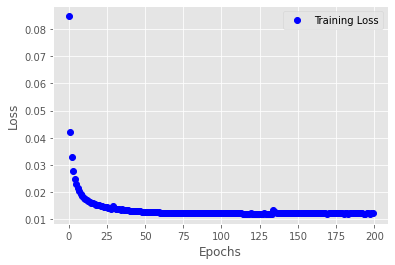

In [11]:
loss = F_AE_history.history['loss']

epochs = range(epochs_number)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
fina_results=np.array(F_AE.evaluate(x_test,[x_test,x_test]))

288/288 [==============================] - 0s 533us/step


In [13]:
fina_results

array([0.01523842, 0.01085357, 0.01515363])

In [14]:
fina_results_single=np.array(F_AE.evaluate(x_test[0:1],[x_test[0:1],x_test[0:1]]))

1/1 [==============================] - 0s 4ms/step


In [15]:
fina_results_single

array([0.02010868, 0.01242357, 0.02001162])

In [16]:
for i in np.arange(x_test.shape[0]):
    fina_results_i=np.array(F_AE.evaluate(x_test[i:i+1],[x_test[i:i+1],x_test[i:i+1]]))
    write_to_csv(fina_results_i.reshape(1,len(fina_results_i)),"./log/results_"+str(sample_used)+".csv")

1/1 [==============================] - 0s 2ms/step
